# Characterize DSM2 missing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# parameters
DSM2_DATA_PATH = "dataset_generating_scripts/DSM2_data/dsm2_ann_observed_1h.xlsx"
SEG_LEN = 72

In [6]:
# read in DSM2 data from file
dsm2_df = pd.read_excel(DSM2_DATA_PATH)

In [7]:
# replace data marked missing (value is -2) with NaN
dsm2_df[dsm2_df.eq(-2)] = np.NaN

# use only important stations
#station_names = dsm2_df.columns[1:]
station_names = ['RSAC064', 'RSAC075', 'RSAC081', 'RSAC092', 'RSAN007','RSAN018']
dsm2_df_filtered = dsm2_df[:][station_names].reset_index()

# reshape data into (sample,measurement,station) dimentions
dsm2_data = dsm2_df_filtered.to_numpy()[:,1:]
num_sampls = int(np.floor(len(dsm2_data)/SEG_LEN))
num_stations = len(station_names)
dsm2_data = np.reshape(dsm2_data[:num_sampls*SEG_LEN,:], (num_sampls,SEG_LEN,num_stations))

# calculate ratio of data is missing
miss_ratio = dsm2_data[np.where(np.isnan(dsm2_data))].size/dsm2_data.size
print('missing data ratio:', miss_ratio)

missing data ratio: 0.034535819714537876


In [8]:
# go through each sample and determine the number of stations with missing data.
# for each station with missing data, determine the length of each missing block
num_stations_missing = np.zeros(num_sampls)
num_missing_blocks   = np.zeros(num_sampls)
missing_block_length = np.zeros(SEG_LEN+1)

for sample in range(num_sampls):
    # check how many stations have missing data; missing data is marked with -2
    miss_stations_count = 0
    num_blocks = 0
    for station in range(num_stations):
        if np.isnan(dsm2_data[sample,:,station]).any():
            miss_stations_count += 1

            # count the number of missing blocks and the length of each block
            
            block_len = 0
            for meas in range(SEG_LEN-1):
                first_meas = dsm2_data[sample,meas,station]
                second_meas = dsm2_data[sample,meas+1,station]

                # 1st meas. missing, end of block
                if np.isnan(first_meas) and ~np.isnan(second_meas):
                    block_len += 1
                    missing_block_length[block_len] += 1
                    num_blocks += 1
                    block_len = 0

                # 2nd meas. missing, start of block
                elif ~np.isnan(first_meas) and np.isnan(second_meas):
                    block_len += 1

                    # check if end of segment
                    if meas == SEG_LEN-2:
                        missing_block_length[block_len] += 1
                        num_blocks += 1
                        block_len = 0
                        
                # both meas. missing start or continuation of block
                elif np.isnan(first_meas) and np.isnan(second_meas):
                    block_len += 1

                    # check if end of segment
                    if meas == SEG_LEN-2:
                        block_len += 1
                        missing_block_length[block_len] += 1
                        num_blocks += 1
                        block_len = 0
                

        # save the number of missing blocks in the sample
        num_missing_blocks[sample] = num_blocks
        
        # save number of missing stations for the sample
        num_stations_missing[sample] = miss_stations_count

Mean number of stations missing in a sample :  0.7226787181594084
Max number of stations missing in a sample  :  6.0
Min number of stations missing in a sample  :  0.0

Mean number of missing blocks in a sample   :  2.342645850451931
Max number of missing blocks in a sample    :  21.0
Min number of missing blocks in a sample    :  0.0

Number of samples with no missing data      :  1194


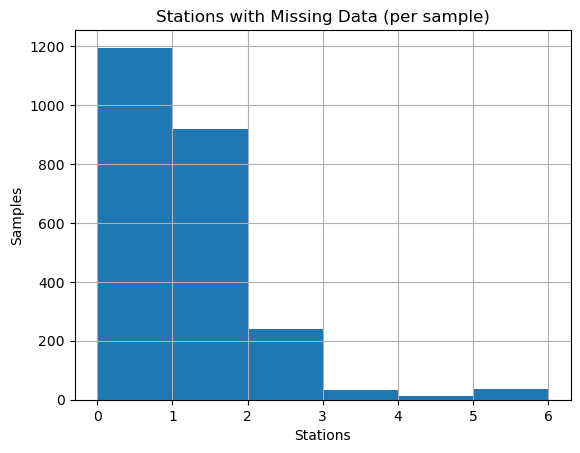

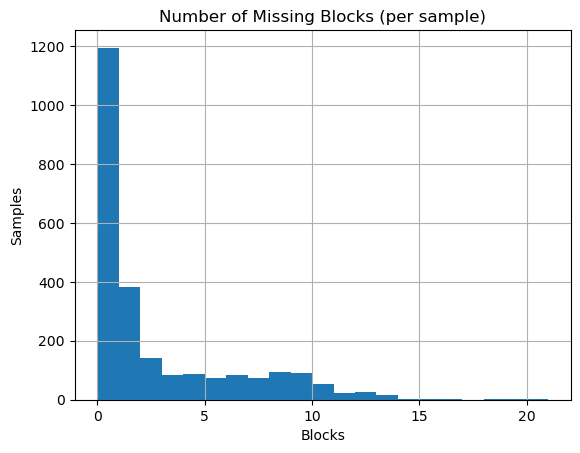

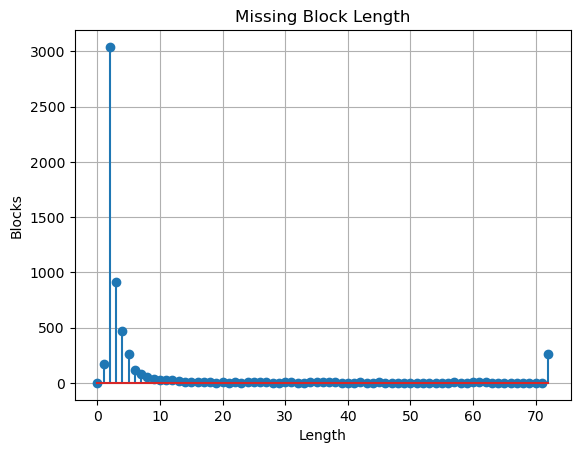

In [9]:
fig = plt.figure()
plt.hist(num_stations_missing, bins=num_stations)
plt.grid(True)
plt.title('Stations with Missing Data (per sample)')
plt.ylabel('Samples')
plt.xlabel('Stations')

print('Mean number of stations missing in a sample : ', np.mean(num_stations_missing))
print('Max number of stations missing in a sample  : ', np.max(num_stations_missing))
print('Min number of stations missing in a sample  : ', np.min(num_stations_missing))

fig = plt.figure()
plt.hist(num_missing_blocks, bins=int(np.max(num_missing_blocks)))
plt.grid(True)
plt.title('Number of Missing Blocks (per sample)')
plt.ylabel('Samples')
plt.xlabel('Blocks')

print('')
print('Mean number of missing blocks in a sample   : ', np.mean(num_missing_blocks))
print('Max number of missing blocks in a sample    : ', np.max(num_missing_blocks))
print('Min number of missing blocks in a sample    : ', np.min(num_missing_blocks))

fig = plt.figure()
plt.stem(missing_block_length)
plt.grid(True)
plt.title('Missing Block Length')
plt.ylabel('Blocks')
plt.xlabel('Length')

print('')
print('Number of samples with no missing data      : ', len(np.where(num_stations_missing==0)[0]))